
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"][["xP"]].head(80).tail(40)

In [5]:
df = df.rename(columns={'GW_x': 'GW'})
# df = df[~(df['position'].isin(['GK']))]
# df = df[df['position'].isin(['MID'])]

In [6]:
# df_original[["expected_goals", "xG"]]

In [7]:
# df_original["goals_conceded"].unique()

In [8]:
# df_original.isnull().sum(axis=0).sort_values(ascending=False).head(60)

In [9]:
# df_original.columns.to_list()

In [10]:
# df["position"].unique()

In [11]:
df.shape

(24683, 117)

# Features

In [12]:
# rolling_gameweeks = [2, 3, 5, 10, 20, 30]
rolling_gameweeks = [2, 4, 30]

to_predict = ["total_points"]
features1 = [
             "Was Home", # Home/Away
             "Team rating", "Opp rating", "Rating Difference" # Team ratings
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xAG', # Expected
                'CS', # Defence
                'Team Score', 'Opp Score', 'Team Result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                # 'bonus', 'bps', # Bonus
                # 'influence', 'creativity', 'threat', 'ict_index', # ICT
                "total_points", "Baseline Points", "bonus" # FPL points
            ]
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "position"]

In [13]:
# df[features_to_roll + info].isnull().sum(axis=0).sort_values(ascending=False).head(30)

# Preparing dataset

In [14]:
df["Rating Difference"] = df["Team rating"] / df["Opp rating"]
# df["Rating Difference2"] = df["Team rating"] > df["Opp rating"]
df["Baseline Points"] = df["total_points"] - df["bonus"]

In [15]:
def calculate_team_points(row):
    if row['Team Score'] > row['Opp Score']:
        return 3
    elif row['Team Score'] == row['Opp Score']:
        return 1
    else:
        return 0
    
df['Team Result'] = df.apply(calculate_team_points, axis=1)

In [16]:
def calculate_xg_points(row):
    if row["position"] == "GK":
        return row["xG"] * 6
    elif row["position"] == "DEF":
        return row["xG"] * 6
    elif row["position"] == "MID":
        return row["xG"] * 5
    elif row["position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [17]:
def calculate_cs_points(row):
    if row["position"] == "GK":
        return row["xG"] * 4
    elif row["position"] == "DEF":
        return row["xG"] * 4
    elif row["position"] == "MID":
        return row["xG"] * 1
    elif row["position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [18]:
def add_rolling_features(df, features1, features_to_roll):
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [19]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [20]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 2,
        'Y*': 1,
        'N': 0,
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [21]:
df = df.reset_index()

In [22]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [23]:
# df, features = ohe(df, ["position"], features)

In [24]:
df = label_encoding(df, "Start")

In [25]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [26]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [27]:
# dropping NaNs
df = df.dropna(axis=0)

In [28]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [29]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline Points_2', 'Baseline Points_30',
       'Baseline Points_4', 'CS_2', 'CS_30', 'CS_4', 'CrdR_2', 'CrdR_30',
       'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'GW', 'Gls_2', 'Gls_30',
       'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name', 'Opp Score_2',
       'Opp Score_30', 'Opp Score_4', 'Opp rating', 'Opponent',
       'Rating Difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Squad', 'Team Result_2', 'Team Result_30',
       'Team Result_4', 'Team Score_2', 'Team Score_30', 'Team Score_4',
       'Team rating', 'Was Home', 'bonus_2', 'bonus_30', 'bonus_4', 'position',
       'total_points', 'total_points_2', 'total_points_30', 'total_points_4',
       'xAG_2', 'xAG_30', 'xAG_4', 'xG_2', 'xG_30', 'xG_4'],
      dtype='object')

In [30]:
df.shape

(22151, 59)

# Choosing features and splitting data

In [31]:
GAMEWEEK_TO_PREDICT = 38
SEASON_TO_PREDICT = "2022-23"

In [32]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [33]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [34]:
X_train.shape, X_test.shape

((21797, 52), (354, 52))

# Model

In [35]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [36]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [37]:
model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [38]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 8.36 s
Wall time: 8.68 s


GradientBoostingRegressor(random_state=42)

# Evaluation

In [39]:
# make predictions on the test data
predictions = model.predict(X_test)

In [40]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [41]:
df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
df_predictions.loc[:, "pred"] = predictions

In [42]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["total_points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [43]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

In [44]:
def evaluate(model, df, predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [45]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [46]:
evaluate(model, df, predictions, y_test)

MAE: 1.7312269395885784
MSE: 6.9261481666210765
Pairwise accuracy: 0.562186904819065
Pairwise accuracy @TOP100: 0.5
Pairwise accuracy @TOP20: 0.6282051282051282


In [47]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [48]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# Valid predictions

In [49]:
preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)

In [50]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
257,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,6.673126
126,Harry-Kane,38,2022-23,Tottenham,Leeds United,0.0,1805.765259,1667.934448,FWD,16.0,5.497363
105,Erling-Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,5.394333
239,Martin-Odegaard,38,2022-23,Arsenal,Wolves,1.0,1918.309692,1724.835327,MID,3.0,5.224923
43,Bukayo-Saka,38,2022-23,Arsenal,Wolves,1.0,1918.309692,1724.835327,MID,6.0,4.806306
119,Gabriel-Jesus,38,2022-23,Arsenal,Wolves,1.0,1918.309692,1724.835327,FWD,12.0,4.804287
234,Marcus-Rashford,38,2022-23,Manchester Utd,Fulham,1.0,1869.084473,1739.748901,MID,2.0,4.740747
92,Eberechi-Eze,38,2022-23,Crystal Palace,Nott'ham Forest,1.0,1760.637085,1669.525391,MID,2.0,4.617099
202,Kieran-Trippier,38,2022-23,Newcastle Utd,Chelsea,0.0,1876.791626,1786.207886,DEF,0.0,4.603546
40,Bruno-Fernandes,38,2022-23,Manchester Utd,Fulham,1.0,1869.084473,1739.748901,MID,10.0,4.595982


In [51]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
105,Erling-Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,5.394333
284,Phil-Foden,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,MID,2.0,3.872297
296,Riyad-Mahrez,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,MID,2.0,3.320165
137,Ilkay-Gundogan,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,MID,0.0,3.187457
188,Julian-Alvarez,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,2.0,3.077919
264,Nathan-Ake,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,DEF,8.0,2.820810
207,Kyle-Walker,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,DEF,2.0,2.789834
27,Aymeric-Laporte,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,DEF,2.0,2.712513
295,Rico-Lewis,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,DEF,2.0,2.631621
301,Rodri,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,MID,0.0,2.514393


In [52]:
# preds[preds["position"] == "FWD"].head(15)

# Feature importance and influence

In [53]:
# plot_importance(model)

In [54]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [55]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 355it [00:28,  8.73it/s]                                                                                                                                    


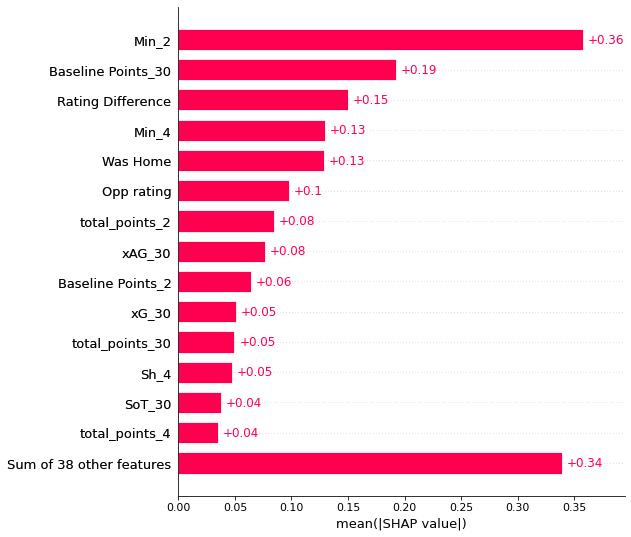

In [56]:
shap.plots.bar(shap_values, max_display=15)

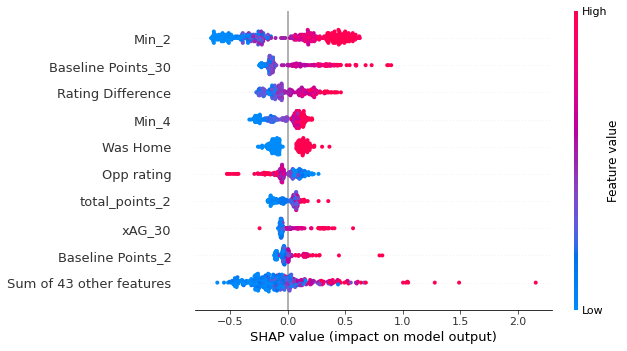

In [57]:
shap.plots.beeswarm(shap_values)

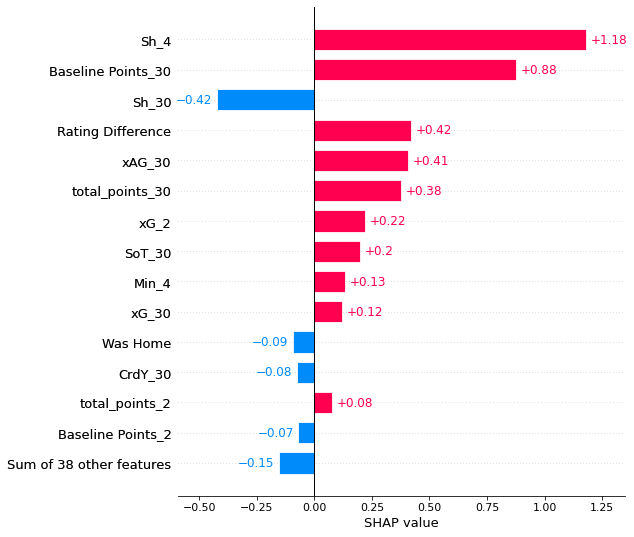

In [58]:
shap.plots.bar(shap_values[105], max_display=15)